# Assignment 5
## Decision Trees and Random Forests for Regression, Part 2

### About this notebook

The general description and instructions as well as questions for the work with Part 2 of the assignment (this notebook) are found in the Assignment description in Canvas!


In [1]:
# YOU DON'T HAVE TO RUN THIS IF EVERYTHING IS ALREADY INSTALLED CORRECTLY
!pip3 install --upgrade pip
!pip3 install graphviz
!pip3 install dtreeviz
!pip3 install numpy scipy

!pip3 install ordered_set

  Using cached pip-24.3.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-24.3.1-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\Users\eajgu\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Step 0: Dataset(s)

First load the dataset you want to use. Ultimately, you should be working with the **California housing data**, but for quicker test runs, it might help to first start out with the **Diabetes data**. For an initial test that your implementation actually works correctly, you should use the **ConceptData**.

In [2]:
from sklearn.datasets import load_diabetes
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split 
import graphviz

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

test_case = 'concept'
#test_case = 'california'
#test_case = 'diabetes'

if test_case == 'california':
    dataset = fetch_california_housing()
elif test_case == 'diabetes':
    dataset = load_diabetes()
elif test_case == 'concept':
    print("running on toy data, actual data will be loaded later")
else:
    raise ValueError('Unknown test case')



running on toy data, actual data will be loaded later


If using real data, split the set into train, validation and test sets.

In [3]:
if (test_case == 'california') or (test_case == 'diabetes'):
    X = dataset.data
    y = dataset.target

    train_ratio = 0.70
    validation_ratio = 0.15
    test_ratio = 0.15
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=0)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=0)
    

## Steps 1-2: Creating and evaluating an ID3-based Regression Tree

The following cells provide some framework for creating / testing your own, ID3-based, regressor. To see that your tree is constructed correctly, some prints are provided (essentially from the lecture) within the handout directory, that are created with the "ConceptData" from the lecture. 

### Step 1:
To make experiments with categorical data, you need to discretize - bin - the data (this goes both for the 'california' and the 'diabetes' cases, for the toy data - 'concept' - case, this is naturally given, note that the data are only loaded below). 
In order to have the entire data set "as is" for the binning, you can prepare a binning rule on the original data (X), that you then apply to your train and test data sets. To make sure that you do not miss any possible attribute values, use the entire set (X) again when providing the categorical values (here bin indices) to the ID3 tree.

In [7]:
from ConceptDataRegr import ConceptDataRegr
import ConceptDataRegr as cd

from sklearn.preprocessing import KBinsDiscretizer
import numpy as np

# For testing that you get the correct output from the ID3 / your score implementation, 
# you can use the "ConceptData" data set (toggle in step 0!):
if test_case == 'concept' :
    attributes, binned_X_train, y_train, binned_X_test, y_test = cd.ConceptDataRegr().get_data()
    binned_X_val = []
    y_val = []
     
else :
    # you might want to try different numbers of bins to see whether using a multivalued branching actually can 
    # improve results over binary decisions only
    
    # ΝΟΤΕ: it is NOT necessary to use the same number of bins for all parameters, e.g. [3,11,4,2,2,7,8,3]
    # could be a really good choice for the California data - or not (no idea if it is, this is just an EXAMPLE)
    
    # HINT: inspect the data set description in part 1 to find suitable numbers - there is, for example, 
    # one feature in the Diabetes data that is binary by nature, so it does not make sense to use anything 
    # else but two bins for that feature
    
    if test_case == 'california':
        bins = [2,2,2,2,2,2,2,2]
    elif test_case == 'diabetes':
        bins = [2,2,2,2,2,2,2,2,2,2]
        
    # here you can test to use different strategies, see the KBinsDiscretizer documentation
    binner = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='kmeans')
    binning_rule = binner.fit(X)
    # use the binning rule
    binned_X = binning_rule.transform(X).astype(int)
    binned_X_train = binning_rule.transform(X_train).astype(int)
    binned_X_val = binning_rule.transform(X_val).astype(int)
    binned_X_test = binning_rule.transform(X_test).astype(int)

    # create an attribute list with "conceptual" features/attributes
    attributes = {}
    i = 0
    for attr in dataset.feature_names :
        attributes[attr] = set(binned_X[:,i])
        i+=1

print(attributes)

{'wind': ['strong', 'weak'], 'airTemp': ['warm', 'cold'], 'humidity': ['normal', 'high'], 'sky': ['sunny', 'cloudy', 'rainy'], 'waterTemp': ['warm', 'cool'], 'forecast': ['same', 'change']}


### Step 2:
Set up and fit the tree, create the dot-data for visualisation. Fill the stubb for *id3_score* below and compare results against the sklearn implementation using different parameters for *max_depth* and *min_samples_leaf*, as well as (many) different binnings. 

Evaluate (on the **California housing data**) two different parameter settings for *max_depth* and *min_samples_leaf* each as well as *two different binnings* (where one should be a binary binning for direct comparison with the SKLearn tree model) in a structured way (e.g. produce a table with the different combinations of parameters). Compare against the **respective same parameter settings** (where possible) for regressor1 from Part 1. 
Hint: there are binnings (non-uniform such) for which the ID3 actually outperforms the CART implementation in SciKitLearn.

Do **not** try to compare to the random forest score from Part 1, that will be the next step!!!

In [16]:
# -------------------------- IMPLEMENTATION TASK BELOW THIS LINE ------------------------  
import ID3_reg

# As of now, the ID3_reg class does not provide any score-method - please replace the stubb below by
# a proper method according to the description of DecisionTreeRegressor.score() for easier 
# comparison with the scikit-learn trees!
    
def id3_score(predicted, target) :
    score = 1.0
        
        # ************************************************
        # Implement your score method here
        # ************************************************

    # residual sum of squares
    u = sum((t - p) ** 2 for t, p in zip(target, predicted))
    #total sum of squares
    mean = sum(target) / len(target)
    v = sum((t - mean)**2 for t in target)
    score = (1-(u/v))

    
        
    return score

# -------------------------------------------------------------------------------------------------

# Now, set up the tree (inspect the ID3_reg class to see the different parameter options, start out with the
# "Concept Data" from the lecture)    
id3 = ID3_reg.ID3RegressionTreePredictor()

# Note: the implementation needs both the complete dictionary over all attributes plus the list of 
# attributes (names only) that are actually to be used for the particular run of fit()
myTree = id3.fit(binned_X_train, y_train, attributes, attributes.keys())

In [17]:
# Do a prediction and scoring on the binned validation and / or test data
predicted = id3.predict(binned_X_test)
print(binned_X_test, predicted) # OBS: printing does not make sense with the "real data"

id3_score(predicted, y_test)

[['strong', 'warm', 'normal', 'cloudy', 'warm', 'change'], ['strong', 'warm', 'normal', 'sunny', 'warm', 'change']] [0.9, 0.9]


-3.9999999999999982

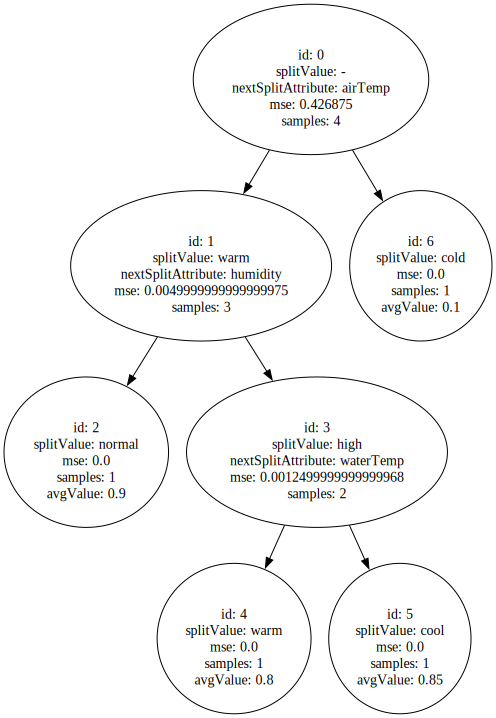

In [18]:
# visualising in the "bubble" format from the lecture
dot_data = id3.makeDotData().source
graph = graphviz.Source(dot_data, format="png")
graph.render(test_case+"_bubbles")
graph

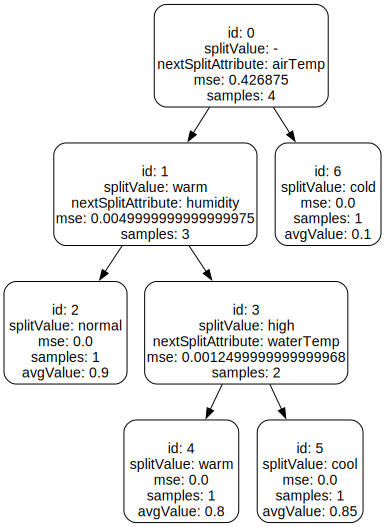

In [19]:
# printing to squares if you want a tree that looks more like those from part 1 ;-)
dot_data_pretty='digraph Tree {\n'+\
    'node [shape=box'+\
    ', style="rounded", color="black"'+\
    ', fontname="helvetica"] ;\n'+\
    'graph [ranksep=equally, splines=polyline] ;\n'+\
    'edge [fontname="helvetica"] ;\n'+\
    dot_data[9:]

graph = graphviz.Source(dot_data_pretty, format="png")
graph.render(test_case+"_pretty")
#graph.view()
graph

## Step3: Your own random forest!
Implement your own random forest (with at least N=5 trees) based on the ID3-implementation you worked with above. Use the best performing data binning from your experiments. As a reminder, the steps for the random forest creation are:
- bootstrap N new datasets from the binned *training* data you created above, sets for validation and test form already the remaining out-of-bootstrap data
- randomise the set of used attributes for each tree (clarification: do the randomisation per tree only, not for each split within the trees)
- create the N trees
- use an ensemble to get the final prediction (e.g. *weighted averaging based on the score for each tree*, for example - NOTE: remember that scores can be negative!)
- evaluate on the out-of-bootstrap data

Motivate your choices and prepare for explaining your implementation in detail!


In [ ]:
# -------------------------- IMPLEMENTATION TASK BELOW THIS LINE ------------------------  
# Implement a random forest based on the ID3 implementation for a regression tree. 
# Evaluate in a fair manner (explain your choice!) against the SKLearn Random Forest you created 
# in Part 1 of the assignment.
# ...

# dummy values, so that the visualisation works, see below

import random


class OurRandomForest:
    def __init__(self, n_trees = 5):
        self.n_trees = n_trees
        self.trees = []
        self.trees_scores = []


    def fit(self, X_train, y_train, attributes, attribute_keys):
        #to get nunmber of ids
        number_of_samples = len(X_train)
        for i in range(self.n_trees):
            # steg ett..
            random_index_list = [random.randInt(0,number_of_samples-1) for _ in range(number_of_samples)]
            X_boostrap = [X_train[id] for id in random_index_list]
            y_bootstrap = [y_train[id] for id in random_index_list]
            remaining_index = list(set(range(number_of_samples)) - set(random_index_list))
            remaining_X = [X_train[id] for id in remaining_index]
            remaining_y = [y_train[id] for id in remaining_index]

            #få randomized subset av attributes (steg 2)
            randomized_attributes = random.sample(attribute_keys, k = max(1, len(attribute_keys)//2))

            random_tree = ID3_reg.ID3RegressionTreePredictor()
            random_tree.fit(X_boostrap,y_bootstrap, attributes, randomized_attributes)
            self.trees.append(random_tree)

            y_remaining_pred = random_tree.predict(remaining_X)
            score = id3_score(y_remaining_pred, remaining_y)
            self.trees_scores.append(max(0,score))

    def predict(self):
        







            



number_of_trees = 2
trees_in_forest = [id3, id3]


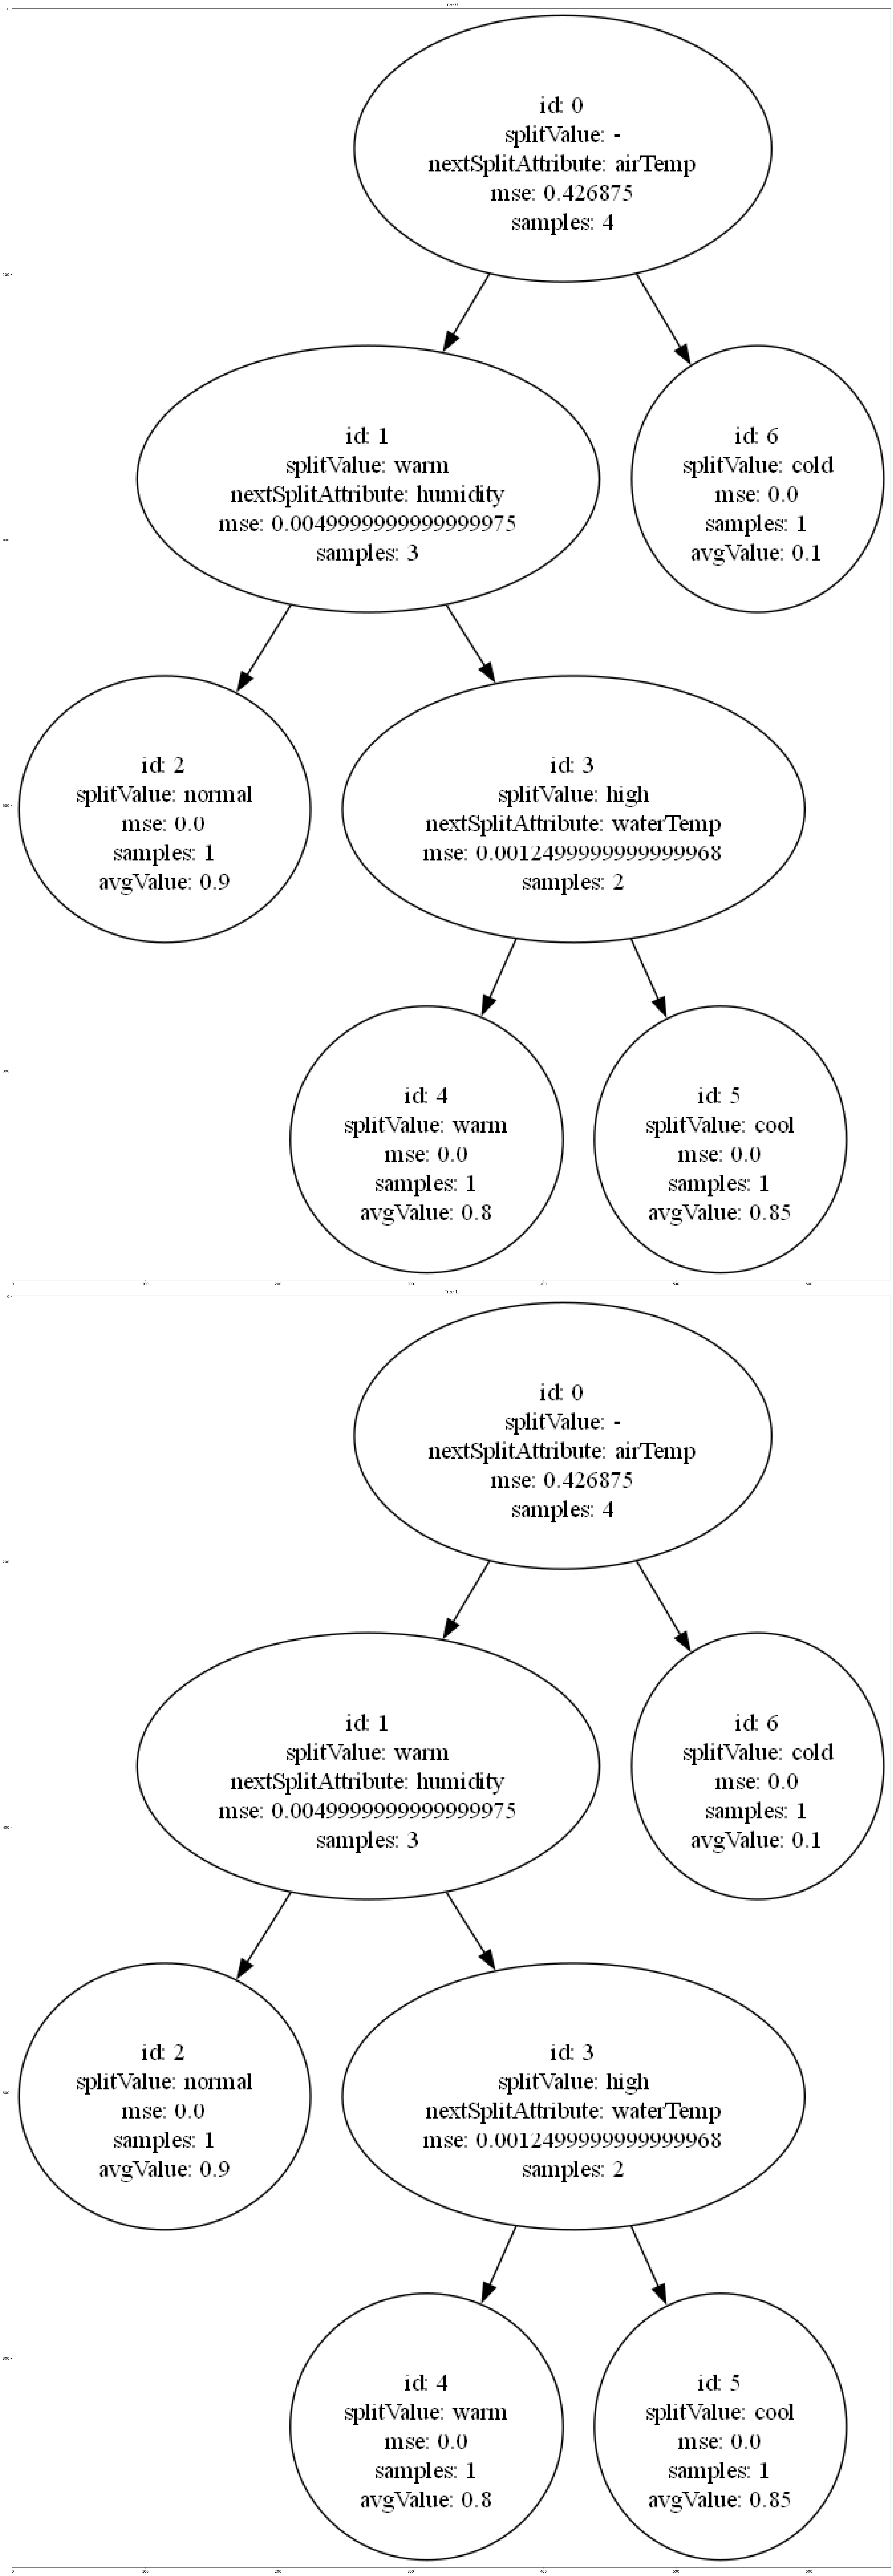

: 

In [ ]:
# One way of visualising your forest - there might be smarter versions!
# OBS: this code assumes number_of_trees and a list with the trees called trees_in_forest
# adapt if needed!

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


graph = []
img_path = []

for i in range(number_of_trees):
    graph.append(graphviz.Source(trees_in_forest[i].makeDotData().source, format="png"))
    img_path.append("forest_"+test_case+str(i))
    graph[i].render(img_path[i])
    
fig, axs = plt.subplots(number_of_trees,1,figsize=(100,100)) # use plt.subplots(number_of_trees/2,2) if you want two columns
for i, axi in enumerate(axs.flat):
    axi.set_title("Tree {}".format(i))
    
    img = mpimg.imread(img_path[i]+".png")
    axi.imshow(img)
fig.tight_layout()
    

